In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import random
random.seed(2024)
from typing import List, Union, Dict, Tuple
from tqdm.autonotebook import trange
from optimum.onnxruntime import ORTModelForFeatureExtraction
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset

C:\Users\clw20\AppData\Local\Temp\ipykernel_17964\807091138.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
def _text_length(text: Union[List[int], List[List[int]]]):
    if isinstance(text, dict):  # {key: value} case
        return len(next(iter(text.values())))
    elif not hasattr(text, "__len__"):  # Object has no len() method
        return 1
    elif len(text) == 0 or isinstance(text[0], int):  # Empty string or list of ints
        return len(text)
    else:
        return sum([len(t) for t in text])  # Sum of length of individual strings
    
def inference(tokenizer: AutoTokenizer, model: ORTModelForFeatureExtraction, 
             sentences: List[str], batch_size:int = 16, verbose: bool =False):
    
    length_sorted_idx = np.argsort([-_text_length(sen) for sen in sentences])
    sentences_sorted = [sentences[idx] for idx in length_sorted_idx]

    embeddings = []

    with tqdm(total=len(sentences), desc="Batches", disable = not verbose) as pbar:
        for i in trange(0, len(sentences), batch_size, desc="Batches", disable = True):
            batch = sentences_sorted[i:i+batch_size]
            encoded_inputs = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(torch.device('cpu'))
            with torch.no_grad():
                output = model(**encoded_inputs)['last_hidden_state'].detach()
                batch_prototypes = torch.mean(output, dim=1)
                batch_prototypes = torch.nn.functional.normalize(batch_prototypes, p=2, dim=1).to(torch.device('cpu'))
                embeddings.extend(batch_prototypes)
            pbar.update(len(batch))

    embeddings = [embeddings[idx] for idx in np.argsort(length_sorted_idx)]
    embeddings = np.asarray([emb.numpy() for emb in embeddings])

    return embeddings

In [3]:
category_dataset = "clw8998/Shopee-Categories"
p_name_dataset = 'clw8998/Coupang-Product-Set-1M'
model_id = 'ckiplab/bert-base-chinese'
batch_size = 16

model = AutoModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

categories = load_dataset(category_dataset, split="train")['category']
p_names = load_dataset(p_name_dataset, split="train")['product_name']

# replace your Start, End here
# p_names = p_names[start: end]
p_names = random.sample(p_names, 10)

Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
print(f"Num of category: {len(categories)}, Num of p_name: {len(p_names)}")

Num of category: 1425, Num of p_name: 10


In [5]:
def get_category(tokenizer: AutoTokenizer, model: ORTModelForFeatureExtraction, 
                 p_names: List[str], categories: List[str], top_k: int = 3) -> Dict[str, List[Tuple[str, float]]]:

    p_names_embeddings = inference(tokenizer, model, p_names, batch_size, verbose=True)  # (n, 768)
    categories_embeddings = inference(tokenizer, model, categories, batch_size, verbose=True)  # (m, 768)
    scores_matrix = np.dot(p_names_embeddings, categories_embeddings.T)  # (n, m)
    
    result = {}
    for i in range(len(p_names)):
        top_k_indices = np.argsort(-scores_matrix[i])[:top_k]
        top_k_with_scores = [(categories[index], scores_matrix[i][index]) for index in top_k_indices]
        result[p_names[i]] = top_k_with_scores

    return result


In [6]:
top_k = 3
result = get_category(tokenizer, model, p_names, categories, top_k=top_k)

Batches: 100%|██████████| 1425/1425 [01:05<00:00, 21.70it/s]


In [7]:
df = pd.DataFrame.from_dict(result, orient='index')
df_expanded = pd.DataFrame(
    df.apply(lambda x: pd.Series([item for sublist in x for item in sublist]), axis=1)
)

columns = []
for i in range(top_k):
    columns.append(f'category_{i+1}')
    columns.append(f'score_{i+1}')

df_expanded.columns = columns
df_expanded = df_expanded.reset_index().rename(columns={'index': 'p_name'})
df_expanded[['class_1', 'class_2', 'class_3']] = df_expanded['category_1'].apply(lambda x: pd.Series(x.split('_'))[:3])
cols = df_expanded.columns.tolist()
new_order = ['p_name', 'class_1', 'class_2', 'class_3', 'category_1'] + cols[2:]

df_expanded = df_expanded[new_order]
df_expanded = df_expanded.loc[:, ~df_expanded.columns.duplicated()]

# df_expanded.to_csv('你的學號_categories.csv', index=False, encoding='utf-8-sig')
df_expanded

,p_name,class_1,class_2,class_3,category_1,score_1,category_2,score_2,category_3,score_3
0,"NS_象牙強化 11吋(櫻花)義大利大圓皿 S001 D5, 1入",女生配件/黃金,髮飾,髮圈 / 大腸圈 / 造型髮圈,女生配件/黃金_髮飾_髮圈 / 大腸圈 / 造型髮圈,0.790971,電玩遊戲_PlayStation_PS系列遊戲,0.789989,女生配件/黃金_眼鏡_鏡框 / 多功能眼鏡,0.782096
1,"StazOn MIDI 郵票油性印台 SZM-63, 茶藍, 1個",女生配件/黃金,其他,補丁 / 布貼,女生配件/黃金_其他_補丁 / 布貼,0.786210,"娛樂、收藏_CD&DVD_CD, DVD 與藍光光碟",0.783742,電玩遊戲_PlayStation_PS系列遊戲,0.783554
2,KARAS MacBook Pro Retina Touch Bar 13.3 MR9V2K...,手機平板與周邊,手機周邊配件,轉接電視棒/ HDMI分享器,手機平板與周邊_手機周邊配件_轉接電視棒/ HDMI分享器,0.824532,3C與筆電_電腦零組件_列印機/掃描機,0.823039,3C與筆電_桌上型電腦_筆電保護膜與保護殼,0.822156
3,"GGOOMIM 兔子與小熊圖案無痕裝飾玻璃門貼, 混色",女生配件/黃金,其他,吊飾 / 吊墜 / 裝飾物,女生配件/黃金_其他_吊飾 / 吊墜 / 裝飾物,0.839143,女生配件/黃金_其他_補丁 / 布貼,0.830384,女生配件/黃金_眼鏡_鏡框 / 多功能眼鏡,0.826275
4,"DANCING TEA 舞間茶心 爆米花 四季春茶, 60g, 5包",美食、伴手禮,飲料、沖泡品,早餐麥片,美食、伴手禮_飲料、沖泡品_早餐麥片,0.796073,美食、伴手禮_飲料、沖泡品_茶葉、茶包,0.793706,美食、伴手禮_飲料、沖泡品_草本漢方飲品,0.792869
5,"Power Action 除霉清潔劑, 150ml, 5個",男女鞋,鞋材用品,除臭劑/ 除臭噴霧,男女鞋_鞋材用品_除臭劑/ 除臭噴霧,0.793074,手機平板與周邊_iPhone保護貼,0.781602,居家生活_日用品_除塵用具、雞毛撢子,0.774525
6,"可愛之家冰箱貼, 4",手機平板與周邊,iPhone保護貼,NaN,手機平板與周邊_iPhone保護貼,0.792668,手機平板與周邊_Android保護貼,0.781639,寵物_寵物玩具_飛盤,0.772505
7,"I'M MEME 我愛奶霜柔霧唇釉, 2.8g, 5支, 06 Berry Pink",美妝保健,專櫃彩妝,BB霜、CC霜,美妝保健_專櫃彩妝_BB霜、CC霜,0.781933,女生配件/黃金_髮飾_髮圈 / 大腸圈 / 造型髮圈,0.780408,美妝保健_開架流行彩妝_口紅、唇膏,0.776874
8,多功能旅行用透明化妝包,美妝保健,美容工具,化妝包,美妝保健_美容工具_化妝包,0.803928,手機平板與周邊_iPhone保護貼,0.803823,戶外/旅行_旅行包款、旅行配件_旅行盥洗組/旅行分裝罐,0.802382
9,Angel In Bedding 蓬鬆防塵超細纖維寢具組,女生衣著,其他,天鵝絨 / 絲綢 / 緞面,女生衣著_其他_天鵝絨 / 絲綢 / 緞面,0.815832,男生衣著_Polo衫,0.811309,居家生活_日用品_除塵用具、雞毛撢子,0.808121


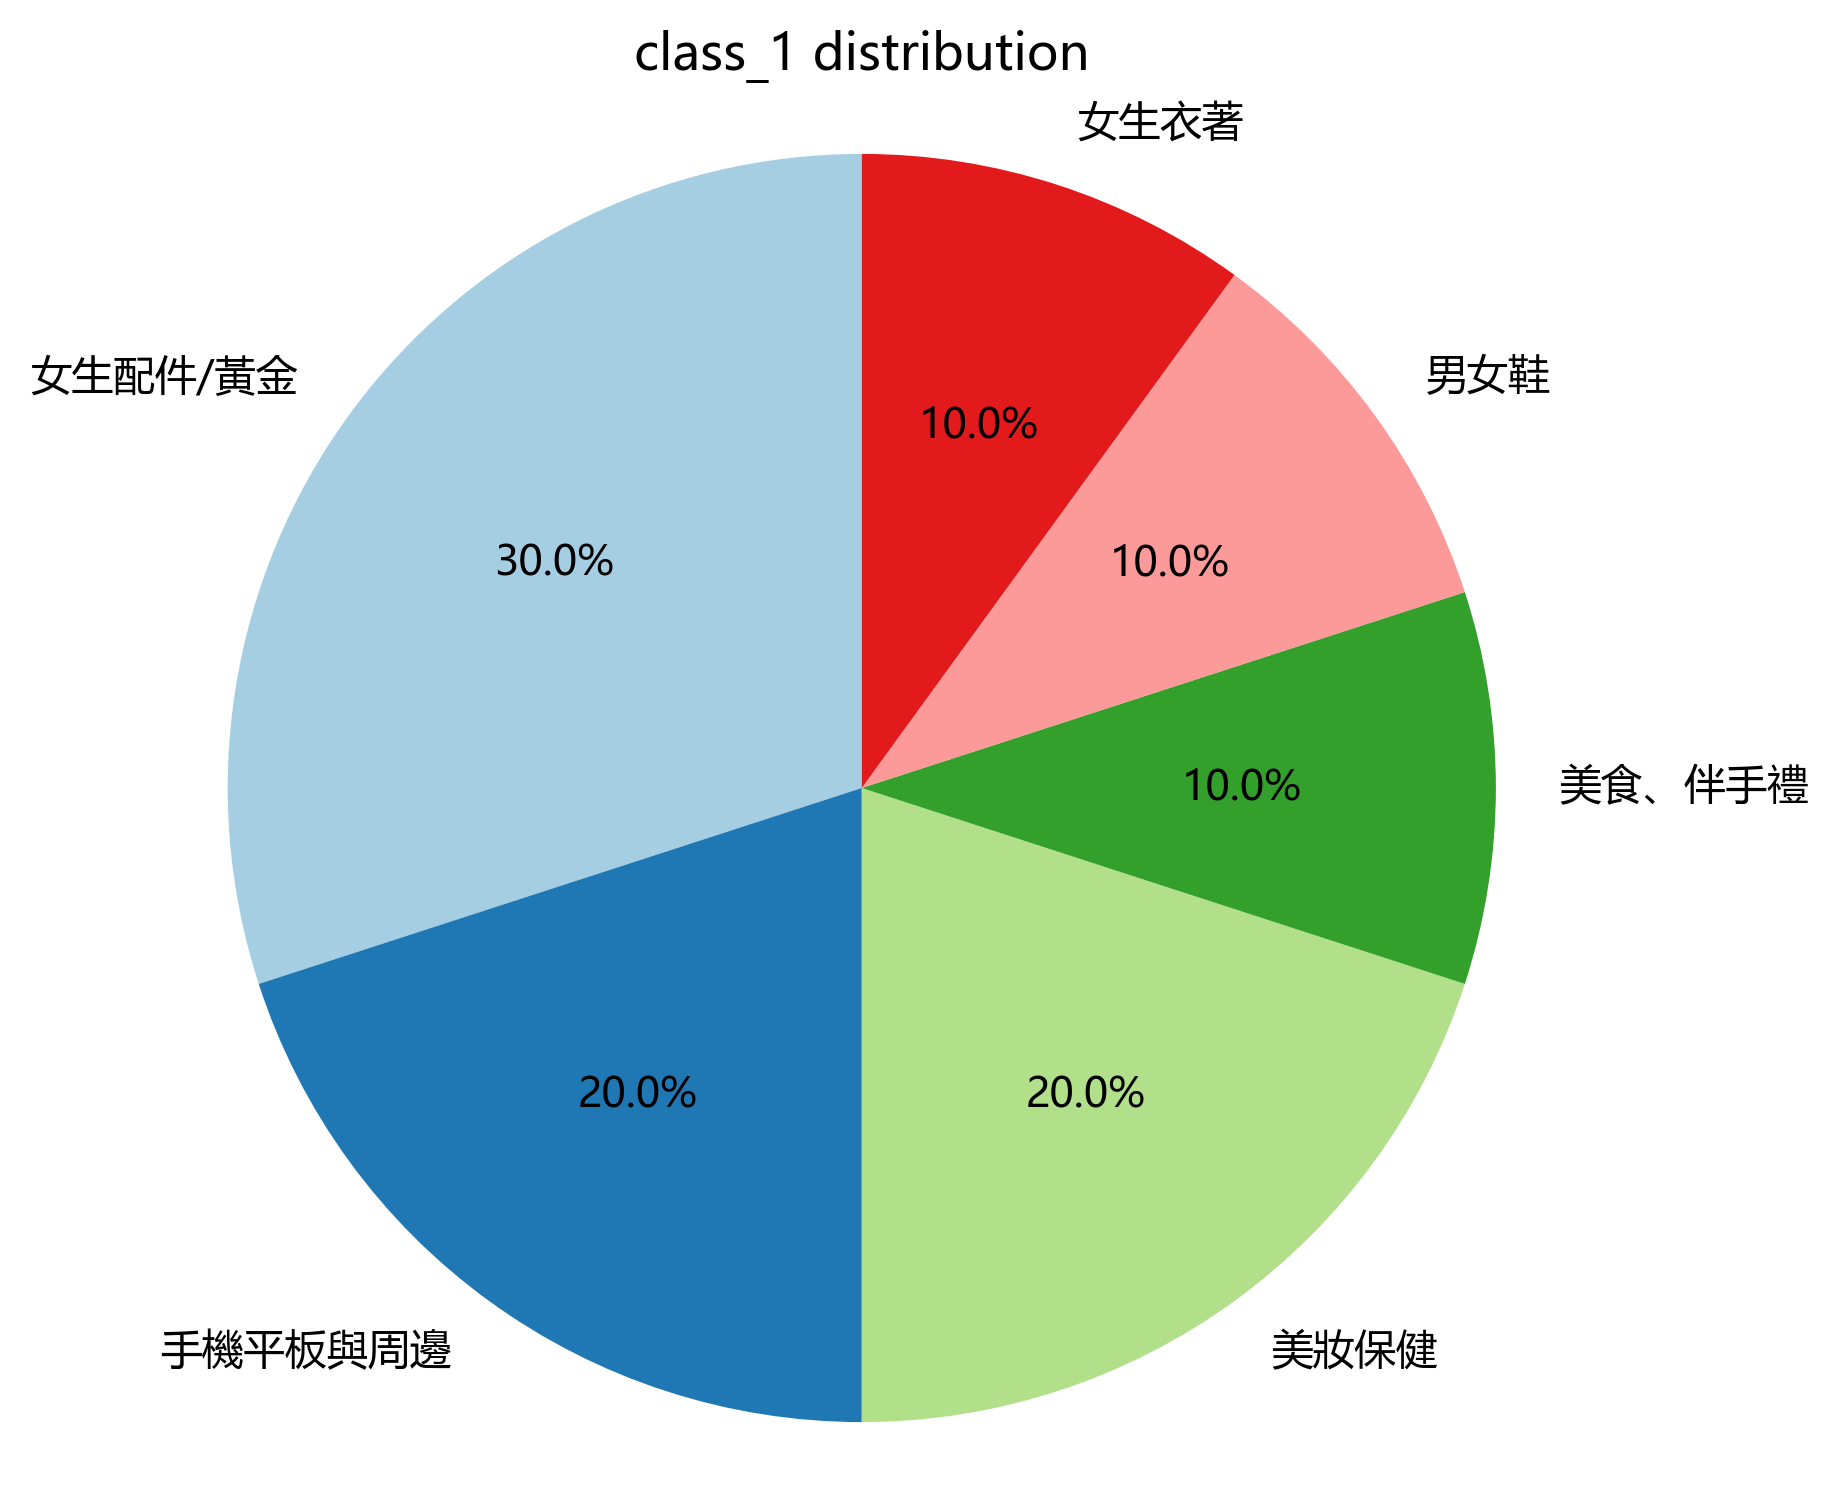

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

class_1_distribution = df_expanded['class_1'].value_counts()

plt.figure(figsize=(6, 6), dpi=300)
plt.pie(class_1_distribution, labels=class_1_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('class_1 distribution')
plt.axis('equal')
# plt.savefig('你的學號_distribution.png', dpi=300) 
plt.show()